In [1]:
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [296]:
# Setting hyperparameters

def inference_model(data, tol, a_0, b_0, lambda_0, mu_0):
    
    data_mean = np.mean(data)
    data_sum_squared = np.dot(data,data)
    
    # Initializing parameters
    old_parameters = 0
    new_parameters = 1
    N = np.size(data)
    E_tao = 1
    mu_N = 0
    
    while np.linalg.norm(new_parameters - old_parameters) > tol:
        
        
        mu_N, lambda_N = VI_mu_update(data, data_mean, N, lambda_0, mu_0, E_tao)
        a_N, b_N = VI_tao_update(data, data_mean,
                                 N, lambda_0, mu_0, a_0, b_0, mu_N, lambda_N)
        E_tao = a_N/b_N
        old_parameters = new_parameters
        new_parameters = np.array([mu_N, E_tao])
        
    return mu_N, lambda_N, a_N, b_N

    
def VI_mu_update(data, data_mean, N, lambda_0, mu_0, E_tao):
    """
    Parameter: data: Nx1 vector of observed variables
    Parameter: data_mean: mean of data vector
    Parameter: lamda_0: hyperparameter; Precision for prior on mu
    Parameter: mu_0: hyperparameter; Mean for prior on mu
    Parameter: E_tao: Expected value of tao
    """
    
    # Variational distriution for mu - Gaussian
    mu_N = (lambda_0*mu_0 + N*data_mean) / (lambda_0 + N)
    lambda_N = (lambda_0 + N)*E_tao
    
    return mu_N, lambda_N

def VI_tao_update(data, data_mean, N, lambda_0, mu_0, a_0, b_0, mu_N, lambda_N):
    
    a_N = a_0 + N/2
    
    first_term = np.dot(data,data) - 2*N*mu_N*data_mean + N*(1/lambda_N + mu_N**2)
    second_term = lambda_0*((1/lambda_N + mu_N**2) - 2*mu_0*mu_N + mu_0**2)
    b_N = b_0 + 0.5*(first_term + second_term)
    
    return a_N, b_N
    
def true_posterior():
    pass


def real_posterior(data, mu, tao, a_0, b_0, lambda_0, mu_0):
    N = np.size(data)
    data_mean = np.mean(data)
    
    a_post = a_0 + N/2
    b_post = b_0 + 0.5 * (np.dot(data,data) + lambda_0*mu_0**2 - (N*data_mean + lambda_0*mu_0)**2/(N+lambda_0))
    
    mu_post = ( N * data_mean + lambda_0*mu_0 )/(N + lambda_0)
    tao_post = tao * (N + lambda_0)
    std_post = np.sqrt(1/tao_post)
    
    gamma_likalihood = stats.gamma.pdf(tao, a_post, loc=0, scale=1/b_post)
    gauss_likelihood = stats.norm.pdf(mu,mu_post,std_post)
    
    return gamma_likalihood * gauss_likelihood

def inferred_posterior(mu, tao, mu_N, lambda_N, a_N, b_N):
    std_N = np.sqrt(1/lambda_N)
    
    gamma_likelihood = stats.gamma.pdf(tao, a_N, loc=0, scale=1/b_N)
    gauss_likelihood = stats.norm.pdf(mu,mu_N,std_N)
    
    return gamma_likelihood * gauss_likelihood


# Constructing data
real_mu = 100
real_tao = 100
N = 1000
sigma = np.sqrt(1/real_tao)
data = np.random.normal(real_mu, sigma, N)

# Hyperparameters
a_0 = 0
b_0 = 0
lambda_0 = 0
mu_0 = 100

mu_N, lambda_N, a_N, b_N = inference_model(data, tol = 1e-30, a_0=a_0,b_0=b_0, lambda_0=lambda_0, mu_0=mu_0)
print(mu_N, a_N/b_N)
E_tao = a_N/b_N

100.00202920405702 98.34556043527151


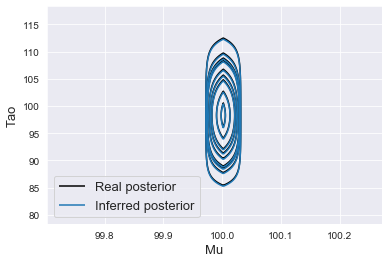

In [302]:
plot_range_x = 0.3
plot_range_y = 20
mu_axis = np.arange(mu_N-plot_range_x, mu_N + plot_range_x, 0.03)
tao_axis = np.arange(E_tao-plot_range_y, E_tao + plot_range_y, 0.03)

nx = np.size(mu_axis)
ny = np.size(tao_axis)

[X,Y] = np.meshgrid(mu_axis, tao_axis)
Z_real = np.asarray([[real_posterior(data, mu, tao, a_0, b_0, lambda_0, mu_0) for tao in tao_axis] for mu in mu_axis])
Z_inferred = np.asarray([[inferred_posterior(mu, tao, mu_N, lambda_N, a_N, b_N) for tao in tao_axis] for mu in mu_axis])

sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 1) 
# plots contour lines 

cntr1 = ax.contour(X, Y, Z_real.T, colors='k', levels=[0.1,0.5,0.8,1,2,3,4,7,10])
cntr2 = ax.contour(X, Y, Z_inferred.T, colors='C0', levels=[0.1,0.5,0.8,1,2,3,4,7,10])
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()

ax.legend([h1[0], h2[0]], ['Real posterior', 'Inferred posterior'], fontsize = 13, loc=3)

plt.xlabel('Mu', fontsize=13)
plt.ylabel('Tao', fontsize=13)
plt.savefig('VI_plot_N_1000-mu_100-tau_100-mu0_100', dpi=300)
plt.show() 